## Section 6 Experiment: Dutycycle + IMU vs Cloudlet Resources

Post process for experiment launched by scripts/run-sec6-dutycycleimu.sh

* multiple clients running the same applications, with and without the techniques mentioned in section 4
* baseline (lego) is:
  * no adaptive/imu suppression
  * multiple workers: 1 worker per core  = 4 workers. 8 cores
* find the frames that are actually within active phase

In [2]:
from __future__ import print_function
import glob
import cStringIO
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.optimize

from rmexp import dbutils, schema
from rmexp.schema import models
from rmexp.dataset_analysis import get_trace_frames, get_ss_df, get_gt_active_df
from rmexp import dataset_analysis as analysis

In [25]:
def _lego_preprocess_remove_multiline(fp):
    with open(fp) as f:
        contents = f.read().splitlines()
    output = cStringIO.StringIO()
    buf = ''

    for idx, line in enumerate(contents):
        if line.count(',,') != 8:
            continue
        buf = line
        nidx = idx+1
        while nidx < len(contents) and contents[nidx].count(',,') != 8:
            buf += ',' + contents[nidx]
            nidx += 1
        output.write(buf+'\n')
    output.seek(0)
    return output


def upload_sec6_exp_data(app, device_type='*', exp_name_regex='*.log'):
    # read in csv
    cvs_fps = glob.glob(
        '/home/junjuew/work/resource-management/data/sec6-res-util/{}/*/{}'.format(
            device_type, exp_name_regex))

    # upload data to db
    sess = dbutils.get_session()
    for cvs_fp in cvs_fps:
        if app == 'lego':
            cvs_fp = _lego_preprocess_remove_multiline(cvs_fp)
        data = pd.read_csv(cvs_fp, sep=',,', header=None, names=[
            'exp', 'fid', 'app', 'client_id', 'arrival_ts', 'finish_ts', 'end_ts', 'util', 'result'])
        exp_suffix = device_type
        app = data.iloc[0]['app']
        client_id = data.iloc[0]['client_id']
        dutycycle_df = get_gt_active_df(app, int(client_id))
        print('{}, app: {}, client_id: {}'.format(cvs_fp, app, client_id))
        if app == 'lego':
            was_active = False
            stage_detected = False
            for index, row in data.iterrows():
                cur_idx = int(row['fid'])
                # whether a frame should be active or not depends both on GT and state detection
                # state-change <----inactive-------> gt active <-----active---> state_change
                if not was_active:
                    if bool(int(dutycycle_df.iloc[cur_idx]['active'])):
                        stage_detected = False
                was_active = bool(int(dutycycle_df.iloc[cur_idx]['active']))
                cur_active = was_active and (not stage_detected)
                if was_active and '!!State Change!!' in row['result']:
                    stage_detected=True
                record = models.Sec6IntraApp(
                    name=row['exp']+exp_suffix, index=cur_idx, app=row['app'], client=row['client_id'],
                    arrival=row['arrival_ts'], finished=row['finish_ts'], reply=row['end_ts'], 
                    utility=row['util'], is_gt_active=cur_active, result=row['result'])
                sess.add(record)

        if app == 'pingpong' or app == 'pool':
            for index, row in data.iterrows():
                cur_idx = int(row['fid'])
                record = models.Sec6IntraApp(
                        name=row['exp']+exp_suffix, index=cur_idx, app=row['app'], client=row['client_id'],
                        arrival=row['arrival_ts'], finished=row['finish_ts'], reply=row['end_ts'], 
                        utility=row['util'], 
                        is_gt_active=dutycycle_df.iloc[cur_idx]['active'], 
                        result=row['result'])
                sess.add(record)
        sess.commit()
    sess.close()
# TODO: the dutycyle and dutycycle + imu data is actually based on 1 frame

# rerun the experiments?
# upload_sec6_exp_data(app='pingpong', device_type='baseline', exp_name_regex='*pingpong*.log')
# upload_sec6_exp_data(app='pingpong', device_type='dutycycleimu', exp_name_regex='*pingpong*.log')

# for app in ['lego']:
#     for dt in ['baseline', 'dutycycle', 'dutycycleimu']:
#         upload_sec6_exp_data(app=app, device_type=dt, exp_name_regex='*{}*.log'.format(app))

# for app in ['pingpong', 'pool']:
#     for dt in ['baseline', 'dutycycleimu']:
#         upload_sec6_exp_data(app=app, device_type=dt, exp_name_regex='*{}*.log'.format(app))

In [26]:
# find utility of an experiment
import pandas as pd

cpus = [2, 4, 6, 8]
def get_data(app, exp_types):
    data = {}
    for exp_type in exp_types:
        data[exp_type] = {}
        for cpu in cpus:
            exp = 'sec6-res-util-{}-c{}m2{}'.format(app, cpu, exp_type)
            df = pd.read_sql(
                "select * from Sec6IntraApp where name=%(name)s",
                 schema.engine,
                 params={'name': exp}
            )
            data[exp_type][cpu] = df
    return data

In [46]:
# %matplotlib notebook
# plot resource cpu to utility
import matplotlib.pyplot as plt

colors = ['navy', 'orange']
fmt=['o-', 'x-', 'o--', 'x--', 'h-.', 's-']
def plot_data(data, exp_types, fmt, labels, ylim=None, title=None):
    lidx = 0
    for idx, exp_type in enumerate(exp_types):
        total_frs = map(lambda x: len(data[exp_type][x].index), cpus)
        print(total_frs)
        plt.plot(cpus, total_frs, fmt[idx], label=labels[lidx], color=colors[idx], linewidth=5, markersize=15)
        lidx += 1

    # plot active frames
    for idx, exp_type in enumerate(exp_types):
        active_frs = map(lambda x: len(data[exp_type][x][data[exp_type][x]['is_gt_active']==1].index), cpus)
        print(active_frs)
        plt.plot(cpus, active_frs, fmt[lidx], label=labels[lidx], color=colors[idx], linewidth=5, markersize=15)
        lidx += 1
    plt.xlabel('CPU Cores', fontsize=35)
    plt.ylabel('Frames', fontsize=35)
    plt.ylim(ylim)
#    plt.title(title, fontsize=18)
#    plt.legend(fontsize=12, loc='best')
    plt.tick_params(labelsize=30)

/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

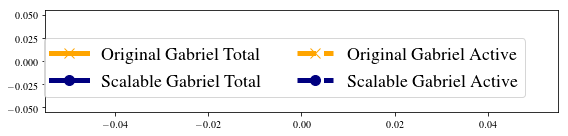

In [3]:
# plot legend
from matplotlib.patches import Patch

legend_colors = ['orange', 'navy']
legend_fmt=['x-', 'o-', 'x--', 'o--']
texts = [ 
    'Original Gabriel Total', 
    'Scalable Gabriel Total', 
    'Original Gabriel Active', 
    'Scalable Gabriel Active',
        ]
plt.figure(figsize=(8, 2))
patches = [plt.plot([],[], legend_fmt[i], color=legend_colors[i%2], 
            label="{:s}".format(texts[i]), linewidth=5, markersize=10)[0]  for i in range(len(texts)) ]
# patches = [Patch(fmt[i], color=colors[i%2], 
#             label="{:s}".format(texts[i]))  for i in range(len(texts))]
plt.tight_layout()
plt.axis('off')
plt.figlegend(patches, texts, ncol=2, loc='center', prop={'weight': 'bold', 'size': 18})
plt.savefig('figs/fig-sec6-reduction-legend.pdf', bbox_inches=0)
plt.axis('on')

[3754, 7406, 12145, 13464]
[4209, 9389, 16583, 17402]
[1786, 3394, 5749, 6044]
[1700, 3297, 5965, 5589]
[1542, 3050, 4789, 4724]
[1589, 2879, 5842, 5935]
[118, 209, 345, 336]
[92, 189, 337, 384]
[2363, 3529, 3358, 3383]
[2935, 6856, 6308, 6036]
[949, 1229, 1271, 1246]
[926, 2012, 1869, 1686]


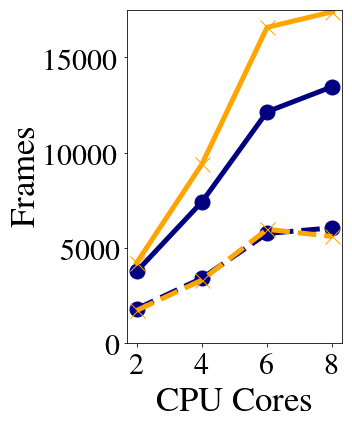

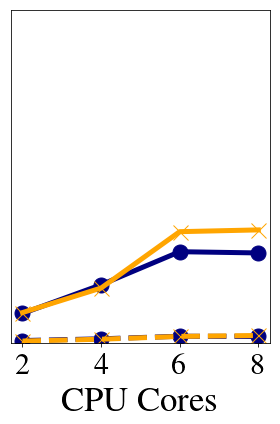

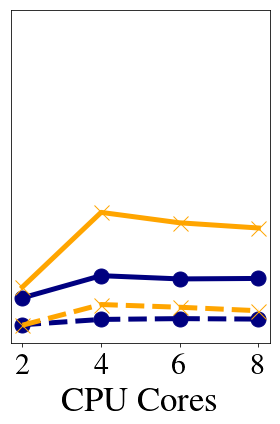

In [48]:
data=get_data('pingpong', exp_types = ['baseline', 'dutycycleimu'])
ticks = [2,4,6,8]
plt.figure(figsize=(5, 6))
plot_data(data, exp_types=['dutycycleimu', 'baseline'], 
          fmt=fmt, 
          labels=[
              'Baseline Total', 
              'Reduced Workload Total', 
              'Baseline Active', 
              'Reduced Workload Active'
                 ],
          title='pingpong',
          ylim=[0, 17500],
         )
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks(ticks)
plt.tight_layout()
plt.savefig('figs/fig-sec6-reduction-{}.pdf'.format('Pingpong'), bbox_inches='tight')

plt.figure(figsize=(4, 6))
data=get_data('pool', exp_types = ['baseline', 'dutycycleimu'])
plot_data(data, exp_types=['dutycycleimu', 'baseline'], 
          fmt=fmt, 
          labels=[
              'Baseline Total', 
              'Reduced Workload Total', 
              'Baseline Active', 
              'Reduced Workload Active'
                 ],
          title='Pool',
          ylim=[0, 17500]
         )
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
cur_axes.axes.get_xaxis().set_ticks(ticks)
plt.tight_layout()
plt.savefig('figs/fig-sec6-reduction-{}.pdf'.format('Pool'), bbox_inches='tight')

plt.figure(figsize=(4, 6))
data=get_data('lego', exp_types = ['baseline', 'dutycycleimu'])
plot_data(data, exp_types=['dutycycleimu', 'baseline'], 
          fmt=fmt, 
          labels=[
              'Baseline Total', 
              'Reduced Workload Total', 
              'Baseline Active', 
              'Reduced Workload Active'
                 ],
          title='Lego',
          ylim=[0, 17500]
)
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
cur_axes.axes.get_xaxis().set_ticks(ticks)
plt.tight_layout()
plt.savefig('figs/fig-sec6-reduction-{}.pdf'.format('Lego'), bbox_inches='tight')

In [58]:
lego_active_gt = {
        'lego-tr1': [
            (230, 330),
            (430, 560),
            (730, 920),
            (1000, 1300),
            (1600, 1760),
            (2088, 2200),
            (2400, 2605),
        ],
        'lego-tr2': [
            (160, 390),
            (600, 850),
            (990, 1250),
            (1300, 1560),
            (1790, 2100),
            (2200, 2480),
            (2700, 2981),
            
        ],
        'lego-tr3': [
            (300, 500),
            (630, 860),
            (1090, 1290),
            (1360, 1660),
            (1800, 2000),
            (2200, 2480),
            (2660, 2858),
        ],
        'lego-tr4': [
            (200, 330),
            (560, 810),
            (1100, 1360),
            (1530, 1750),
            (1950, 2130),
            (2450, 2660),
            (2860, 3030),
            
        ],
        'lego-tr6': [
            (150, 330),
            (600, 800),
            (1400, 1560),
            (2200, 2440),
            (2700, 2900),
            (3240, 3500),
            (3850, 4083),
            
        ]
}

ikea_active_gt = {
        'ikea-tr1': [
            (6*30, 11*30),
            (23*30, 30*30),
            (39*30, 47*30),
            (71*30, 85*30),
            (92*30, 99*30),
            (122*30, 128*30),
            (137*30, 148*30),
            (162*30, 174*30),
        ],
        'ikea-tr3': [
            (6*30, 15*30),
            (30*30, 40*30),
            (52*30, 59*30),
            (84*30, 93*30),
            (102*30, 109*30),
            (131*30, 138*30),
            (144*30, 155*30),
            (167*30, 179*30),
        ],
        'ikea-tr4': [
            (5*30, 14*30),
            (27*30, 37*30),
            (43*30, 51*30),
            (66*30, 98*30),
            (104*30, 110*30),
            (133*30, 138*30),
            (144*30, 158*30),
            (168*30, 180*30),
        ],
        'ikea-tr5': [
            (6*30, 12*30),
            (30*30, 38*30),
            (45*30, 52*30),
            (76*30, 94*30),
            (108*30, 114*30),
            (134*30, 140*30),
            (144*30, 157*30),
            (166*30, 178*30),
        ],    
}

import pandas as pd
from rmexp.schema import models
from rmexp import schema, dbutils
import json
def upload_dutycycle_gt(active_gt):
    # upload gt data to db
    sess = dbutils.get_session()
    for trace, gts in active_gt.iteritems():
        app = trace.split('-')[0]
        trace_id = trace[-1]
        df = pd.read_sql(
            "select value from DataStat where app=%(app)s and trace=%(trace_id)s",
            schema.engine,
             params={'app': app, 'trace_id': trace_id}
        )
        datastat = json.loads(df['value'].iloc[0])
        total_frs = datastat['frames']
        print('total frames: {}'.format(total_frs))
        active = ['0'] * total_frs
        for (st, end) in gts:
            for i in range(st, end+1):
                active[i] = '1'
        for idx, is_active in enumerate(active):
            record = models.DutyCycleGT(
                name=app, trace=trace_id, index=idx, active=is_active
            )
            sess.add(record)
    sess.commit()
    sess.close()

# upload_dutycycle_gt(ikea_active_gt)